In [1]:
import sys
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from transformers import PatchTSTConfig, PatchTSTForPrediction

path_root = '../anomaly_detection/'
sys.path.append(str(path_root))

from detectors import create_dataset

torch.set_default_dtype(torch.double)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/u/yzhang39/miniconda3/envs/jupy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
def calculate_self_tracin(
    model: torch.nn.Module,
    weights_paths: [str or Path],
    train_dataloader: torch.utils.data.DataLoader,
    work_dir: str or Path,
    nu_for_each_epoch: None
):
    '''Compute self-influence using TracIn.'''
    
    LR = nu_for_each_epoch

    score_matrix = np.zeros((len(train_dataloader)))

    for train_id, (x_train, y_train) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='TracIn'):
        grad_sum = 0

        for w in weights_paths:
            model = PatchTSTForPrediction(config).to(device)
            model.load_state_dict(torch.load(w)) # checkpoint
            model.eval()
            inputs, targets = x_train.to(device), y_train.to(device)
            outputs = model(
                past_values=inputs,
                future_values=targets,
            )
            preds = outputs.prediction_outputs
            loss = nn.MSELoss()(targets, preds)
            loss.backward() # back
            train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters() if param.grad is not None])

            grad_sum += LR * np.dot(train_grad, train_grad) 

        score_matrix[train_id] = grad_sum

    return score_matrix


def calculate_tracin_score(
    model: torch.nn.Module,
    weights_paths: [str or Path],
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    work_dir: str or Path,
    nu_for_each_epoch: None
):
    '''Compute data influence on test predictions using TracIn.'''
    
    LR = nu_for_each_epoch

    score_matrix = np.zeros((len(train_dataloader), len(test_dataloader)))

    for train_id, (x_train, y_train) in tqdm(enumerate(train_dataloader), total=len(train_dataloader), desc='TracIn'):

        for test_id, (x_test, y_test) in enumerate(test_dataloader):
            grad_sum = 0

            for w in weights_paths:
                model = PatchTSTForPrediction(config).to(device)
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                inputs, targets = x_train.to(device), y_train.to(device)
                outputs = model(
                    past_values=inputs,
                    future_values=targets,
                )
                preds = outputs.prediction_outputs
                loss = nn.MSELoss()(targets, preds)
                loss.backward() 
                train_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters() if param.grad is not None])

                model = PatchTSTForPrediction(config).to(device)
                model.load_state_dict(torch.load(w)) # checkpoint
                model.eval()
                inputs, targets = x_train.to(device), y_train.to(device)
                outputs = model(
                    past_values=inputs,
                    future_values=targets,
                )
                preds = outputs.prediction_outputs
                loss = nn.MSELoss()(targets, preds)
                loss.backward() # back
                test_grad = torch.cat([param.grad.reshape(-1) for param in model.parameters() if param.grad is not None])

                grad_sum += LR * np.dot(train_grad, test_grad) 

            score_matrix[train_id][test_id] = grad_sum

    return score_matrix

In [2]:
block_length = 50
n_samples = 2000

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
ts = bike_sharing['target'].to_numpy().reshape(-1,1)[:n_samples]
seq_len, n_dim = ts.shape

scaler = StandardScaler().fit(ts)
ts = scaler.transform(ts)
ts = ts.squeeze()

ts_train, ts_test = ts[:int(len(ts)*.8)], ts[int(len(ts)*.8):]
X_train, Y_train = create_dataset(ts_train, block_length=block_length, device=device)
X_train, Y_train = X_train[:,:,None], Y_train[:,-1,None,None]
X_test, Y_test = create_dataset(ts_test, block_length=block_length, device=device)
X_test, Y_test = X_test[:,:,None], Y_test[:,-1,None,None]
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

torch.Size([1550, 50, 1]) torch.Size([1550, 1, 1])
torch.Size([350, 50, 1]) torch.Size([350, 1, 1])


/u/yzhang39/time-series-influence/demo/../anomaly_detection/detectors.py:326: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(X).to(device), torch.tensor(Y).to(device)


In [3]:
# batch size = 1 otherwise TracIn will assign the same score to all time blocks in the batch
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, Y_train), shuffle=True, batch_size=1
)
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, Y_train), shuffle=False, batch_size=1
)

In [4]:
# https://huggingface.co/docs/transformers/en/model_doc/patchtst#transformers.PatchTSTConfig

config = PatchTSTConfig(
    num_input_channels=n_dim,         
    context_length=block_length,      # context length of the input sequence
    patch_length=5,                   # each patch is a token
    prediction_length=1,              # prediction horizon (one-step ahead in our setting)
    num_hidden_layers=1,
    d_model=16,
    num_attention_heads=1,
    ffn_dim=32,
    attention_dropout=0.,
    dropout=0.,
    random_mask_ratio=0.1,
    num_targets=1,
)

In [6]:
learning_rate = 0.01 
model = PatchTSTForPrediction(config).to(device)
# TracIn only works with SGD 
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0)
n_epochs = 50 # for demo purpose and increase as needed
weights = [] # use this to collect checkpoints

In [7]:
for epoch in range(1, n_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # inputs: (bs, block_len, n_dim)
        # preds:  (bs, forecast_len, n_dim)
        inputs, targets = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(
            past_values=inputs,
            future_values=targets,
        )
        preds = outputs.prediction_outputs
        loss = nn.MSELoss()(targets, preds)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
    print(f'epoch: {epoch} loss: {running_loss / len(train_loader):.5f}')
    running_loss = 0.0

    # IMPORTANT: need to hand-pick when to save checkpoints.
    # we can choose fewer checkpoints to speed up computation.
    # the authors recommended to use checkpoints with larger loss reduction,
    #     i.e., earlier epochs when loss is still decreasing but 
    #     not too early to ensure TracIn scores are meaningful.
    #     see here: https://drive.google.com/file/d/1zL3hwW4wFru49_-zwpmliRDdCahjumXa/view
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'model_v1_epoch_{epoch}')
        weights.append(f'model_v1_epoch_{epoch}')

print('Finished Training!')

epoch: 1 loss: 0.77306
epoch: 2 loss: 0.76013
epoch: 3 loss: 0.69694
epoch: 4 loss: 0.62660
epoch: 5 loss: 0.60979
epoch: 6 loss: 0.61019
epoch: 7 loss: 0.60539
epoch: 8 loss: 0.60663
epoch: 9 loss: 0.60142
epoch: 10 loss: 0.59776
epoch: 11 loss: 0.60037
epoch: 12 loss: 0.59608
epoch: 13 loss: 0.59582
epoch: 14 loss: 0.59290
epoch: 15 loss: 0.59579
epoch: 16 loss: 0.58969
epoch: 17 loss: 0.59311
epoch: 18 loss: 0.59415
epoch: 19 loss: 0.59005
epoch: 20 loss: 0.59547
epoch: 21 loss: 0.58683
epoch: 22 loss: 0.59398
epoch: 23 loss: 0.58906
epoch: 24 loss: 0.58544
epoch: 25 loss: 0.59166
epoch: 26 loss: 0.58966
epoch: 27 loss: 0.58673
epoch: 28 loss: 0.59061
epoch: 29 loss: 0.58485
epoch: 30 loss: 0.58939
epoch: 31 loss: 0.58798
epoch: 32 loss: 0.58679
epoch: 33 loss: 0.58842
epoch: 34 loss: 0.58528
epoch: 35 loss: 0.58286
epoch: 36 loss: 0.58547
epoch: 37 loss: 0.58054
epoch: 38 loss: 0.58075
epoch: 39 loss: 0.58260
epoch: 40 loss: 0.58489
epoch: 41 loss: 0.58234
epoch: 42 loss: 0.58116
e

In [8]:
# validate patchTST
model.eval()
test_targets, test_preds = [], []
for i, data in enumerate(test_loader):
    inputs, targets = data
    inputs, targets = inputs.to(device), targets.to(device)

    outputs = model(
        past_values=inputs,
        future_values=targets,
    )
    preds = outputs.prediction_outputs
    test_targets.append(targets)
    test_preds.append(preds)
test_targets = torch.concat(test_targets).squeeze().detach().numpy()
test_preds = torch.concat(test_preds).squeeze().detach().numpy()

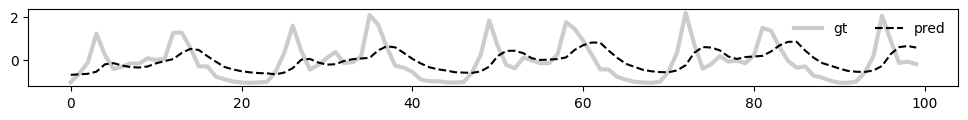

In [14]:
plt.figure(figsize=(12, 1))
plt.plot(test_targets[:100], c='k', linewidth=3, alpha=.2, label='gt')
plt.plot(test_preds[:100], c='k', linestyle='--', label='pred')
plt.legend(ncol=2, frameon=False)
plt.show()

In [17]:
# compute self-influence for each time block
# we still need to compute self-influence for each time point
#    and then obtain the anomaly scores.

IF_block = calculate_self_tracin(
    model=PatchTSTForPrediction(config),
    weights_paths=weights,
    train_dataloader=train_loader,
    work_dir=None, nu_for_each_epoch=learning_rate
)

TracIn: 100%|██████████| 1550/1550 [00:39<00:00, 39.69it/s]


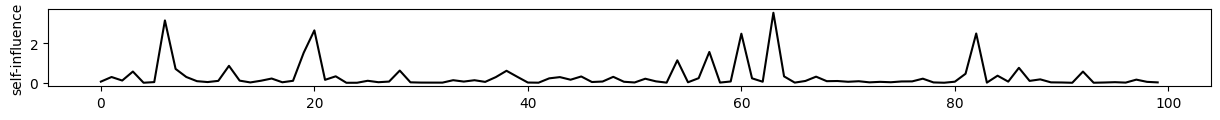

In [19]:
plt.figure(figsize=(15,1))
plt.plot(IF_block[100:200], c='k')
plt.ylabel('self-influence')
plt.show()